In [7]:
import networkx as nx
from enum import Enum
import numpy as np
import copy
import random
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import itertools
import operator

In [8]:
import util

In [9]:
import strategy_vector_manipulator as strategy

In [10]:
import init_sentiment

In [11]:
import stubborn_nodes

In [12]:
# !pip install networkit
# !pip install oct2py
# import get_BTER_graph

In [13]:
def threshold_process(S0, theta, graph, verbose):
    'S0 is a set, theta is the threshold vector'

    V = set(graph)
    t = 0
    S = S0
    
    #calculate each node's d(i, S0) first
    dS = {}
    
    for i in V:
        dsi = 0
        for j in graph.neighbors(i):
            if j in S:
                dsi += 1
        dS.update({i:dsi})
    
#     print("initial dS: ", dS)
    
    new_added = True
    
    while(new_added):
        t += 1
        new_added = False
        
        for i in V.difference(S):
            if dS[i] >= theta[i]:
                S.add(i) ## add the node to set S
                new_added = True
                
                ## now increment the dS of i's neighbors
                for j in graph.neighbors(i):
                    dS[j] += 1
            
        if(verbose):
            print("t = ", t, ", S = ", S, '\n')
    
    if(verbose):
        print("T = ", t)
        print("S_T = ", S)
    
    return S

In [15]:
def get_theta(graph, alpha, C):
    'θv = d(v)/2 − Cv/ 2α'
    
    theta = {}
    
    for i in graph.nodes:
        theta_i = graph.degree(i) /2 - C[i]/(2*alpha)
        theta.update({i:theta_i})
    
    return theta

In [17]:
def get_S0(alpha, C, graph):
    S0 = set()
    for i in graph.nodes:
        if(graph.degree(i) < C[i]/alpha):
            S0.add(i)
    return S0

#sanity check
# C = [-1 for i in range(len(g))]
# S0 = get_S0(alpha = 1, C = C, graph = g)

# theta = get_theta(graph= g, alpha = 1, C = C)

# S_T = threshold_process(S0= S0, theta = theta, graph = g, verbose=True)

# len(S_T)

In [209]:
'''Load Graph'''
############# params of graph ############################
N = 1000
M = 20
PROB_TRIANGLE = 0.3
prob_edge = 0.2
#########################################################
# g = nx.erdos_renyi_graph(n=N, p = prob_edge, seed = 42)
# g = nx.read_edgelist("../data/facebook_combined.txt", create_using = nx.Graph(), nodetype=int) ########### snap facebook data #############
# g = nx.read_edgelist("../data/email-EU-core.txt", create_using = nx.Graph(), nodetype=int) ########### snap facebook data #############
# g = nx.read_edgelist("../data/p2p-Gnutella04.txt", create_using = nx.Graph(), nodetype=int) ########### snap facebook data #############
g = nx.read_gexf("../data/twitter_sentiment_200.gexf", node_type=None, relabel=False, version='1.1draft')

n = len(g)
m = g.number_of_edges()
# triangles = sum(nx.triangles(g).values())//3
davg = sum(dict(g.degree).values())/len(g)
ccavg = nx.average_clustering(g)


print('|V| = ', n)
print('|E| = ', m)
# print('Triangles: ', triangles)
print('Avg degree: ', davg)
print('CC_avg: ', ccavg)

print(n, ' & ', m , ' & ', davg , ' & ', ccavg)

|V| =  9527
|E| =  82709
Avg degree:  17.36307337042091
CC_avg:  0.05051460526371834
9527  &  82709  &  17.36307337042091  &  0.05051460526371834


In [210]:
# nx.draw(g)

136.0


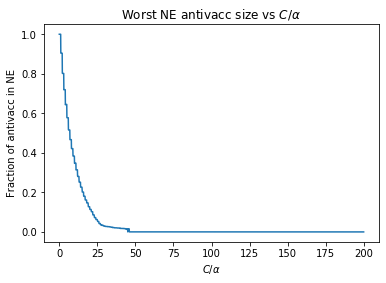

In [211]:
start = 0
end = 200
interval = 0.1
C_list = [{j:np.arange(start, end, interval)[i]  for j in g.nodes} for i in range(len(np.arange(start, end, interval)))]

c = np.arange(start, end, interval)
worst_NE_size = []

alpha = 1

for C in C_list:
    S0 = get_S0(alpha = alpha, C = C, graph = g)

    theta = get_theta(graph= g, alpha = alpha, C = C)

    S_T = threshold_process(S0 = S0, theta = theta, graph = g, verbose=False)

#     print(S_T)
    
    worst_NE_size.append(len(g)-len(S_T))
    

for i in range(len(worst_NE_size)):
    if(worst_NE_size[i]  == 0 ):
        print(c[i])
        break
    
plt.plot(c, np.array(worst_NE_size)/len(g))
plt.xlabel(r'$C/\alpha$')
plt.ylabel('Fraction of antivacc in NE')
plt.title('Worst NE antivacc size vs' + r' $C/\alpha$')
plt.savefig('fig.eps')

# set(g).difference(S_T)


In [212]:
wtwitter = worst_NE_size

In [213]:
wne = [werdos, wtwitter, wfb, wp2p, wemail]
legend = ['Erdos-Renyi', 'Twitter Mentions', 'Facebook', 'Gnutella p2p', 'email-EU-core']


In [214]:
# heh10 = set(g).difference(S_T)
# np.save('heh10', list(heh10))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


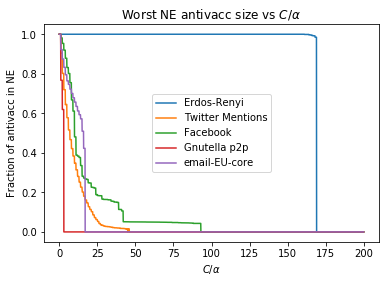

In [215]:
for w in wne:
    plt.plot(c, np.array(w)/w[0])
    
# plt.plot(c, np.array(wne[0])/wne[0][0], color='red')
    
    
plt.xlabel(r'$C/\alpha$')
plt.ylabel('Fraction of antivacc in NE')
plt.title('Worst NE antivacc size vs' + r' $C/\alpha$')
plt.legend(legend)
plt.savefig('wne.eps')

5.0
28.0
52.0
78.0
105.0
131.0
159.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


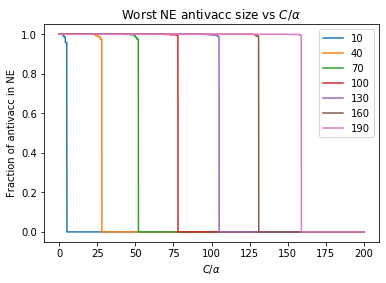

In [28]:
'7.2'

start = 0
end = 200
interval = 0.1

c = np.arange(start, end, interval)

alpha = 1

wd = {}

for p in range(0,1, 0.05):
    N = 1000
    g = nx.erdos_renyi_graph(n=N, p = prob_edge, seed = 42)
    
    C_list = [{j:np.arange(start, end, interval)[i]  for j in g.nodes} for i in range(len(np.arange(start, end, interval)))]
    
    worst_NE_size = []

    for C in C_list:
        S0 = get_S0(alpha = alpha, C = C, graph = g)

        theta = get_theta(graph= g, alpha = alpha, C = C)

        S_T = threshold_process(S0 = S0, theta = theta, graph = g, verbose=False)

        worst_NE_size.append(len(g)-len(S_T))

    wd.update({d:worst_NE_size})

    for i in range(len(worst_NE_size)):
        if(worst_NE_size[i] == 0):
            print(c[i])
            break

            
            for d in wd:
    plt.plot(c, np.array(wd[d])/wd[d][0])


plt.xlim(0, 230)

plt.xlabel(r'$C/\alpha$')
plt.ylabel('Fraction of antivacc in NE')
plt.title('Worst NE antivacc size vs' + r' $C/\alpha$')


legend = list(wd.keys())
legend = [r'$E[d] = $' + str(legend[i]) for i in range(len(legend))]

plt.legend(legend)
plt.savefig('wd.eps')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


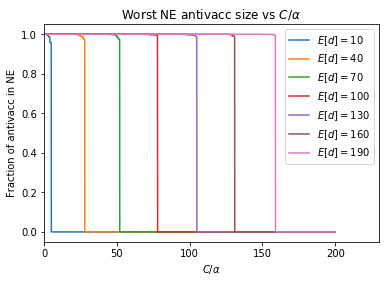

In [71]:
'7.2'

start = 0
end = 1001
interval = 1

c = np.arange(start, end, interval)

alpha = 1

wd = {}

for p in np.arange(0, 1, 0.2):
    N = 1000
    g = nx.erdos_renyi_graph(n=N, p = p, seed = 42)
    
    C_list = [{j:np.arange(start, end, interval)[i]  for j in g.nodes} for i in range(len(np.arange(start, end, interval)))]
    
    worst_NE_size = []

    for C in C_list:
        S0 = get_S0(alpha = alpha, C = C, graph = g)

        theta = get_theta(graph= g, alpha = alpha, C = C)

        S_T = threshold_process(S0 = S0, theta = theta, graph = g, verbose=False)

        worst_NE_size.append(len(g)-len(S_T))

    wd.update({p:worst_NE_size})

    for i in range(len(worst_NE_size)):
        if(worst_NE_size[i] == 0):
            print(c[i])
            break

0
169
355
552
758


C:\Users\ah3wj\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


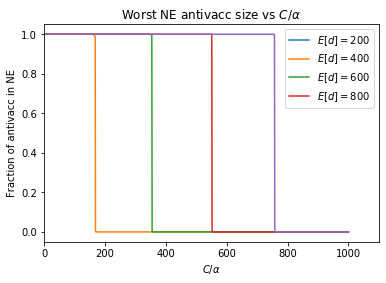

In [77]:
for d in wd:
    plt.plot(c, np.array(wd[d])/wd[d][0])


plt.xlim(0, 1100)

plt.xlabel(r'$C/\alpha$')
plt.ylabel('Fraction of antivacc in NE')
plt.title('Worst NE antivacc size vs' + r' $C/\alpha$')


legend = [200,400,600,800]
legend = [r'$E[d] = $' + str(legend[i]) for i in range(len(legend))]

plt.legend(legend)
plt.savefig('wp.eps')

In [135]:
'7.6'

# g = nx.erdos_renyi_graph(n=N, p = prob_edge, seed = 42)
# g = nx.expected_degree_graph(w=[20 for i in range(N)], seed=42)
# g = nx.read_edgelist("../data/facebook_combined.txt", create_using = nx.Graph(), nodetype=int) ########### snap facebook data #############
# g = nx.read_edgelist("../data/twitter_combined.txt", create_using = nx.Graph(), nodetype=int) ########### snap facebook data #############
# g = nx.read_edgelist("../data/email-EU-core.txt", create_using = nx.Graph(), nodetype=int) ########### snap facebook data #############
g = nx.read_edgelist("../data/p2p-Gnutella04.txt", create_using = nx.Graph(), nodetype=int) ########### snap facebook data #############
# g = nx.read_gexf("../data/twitter_sentiment_200.gexf", node_type=None, relabel=False, version='1.1draft')
# d = 5
# g = nx.random_regular_graph(d=d, n = N, seed = 42)



start = 0
end = 5
interval = 0.1
C_list = [{j:np.arange(start, end, interval)[i]  for j in g.nodes} for i in range(len(np.arange(start, end, interval)))]

c = np.arange(start, end, interval)
worst_NE_size = []

alpha = 1

sorted_graph = sorted(g.degree, key = lambda x: x[1], reverse=True)





for k in range(0,1001,5):
  worst_NE_size = []
  Dk = set([sorted_graph[:k][i][1] for i in range(k)])

  for C in C_list:
      S0 = get_S0(alpha = alpha, C = C, graph = g).union(Dk)

      theta = get_theta(graph= g, alpha = alpha, C = C)

      S_T = threshold_process(S0 = S0, theta = theta, graph = g, verbose=False)
      
      worst_NE_size.append(len(g)-len(S_T))
  
  for i in range(len(worst_NE_size)):
      if(worst_NE_size[i] == 0):
          print(c[i], end=', ')
          break

3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 

KeyboardInterrupt: 

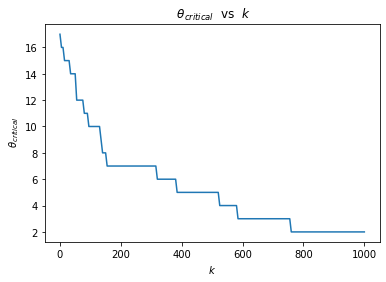

In [140]:
x = range(0,1001,5)

yemail = [17, 16, 16, 15, 15, 15, 15, 14, 14, 14, 14, 12, 12, 12, 12, 12, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 9, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
yerdos = [169, 167, 167, 165, 165, 164, 163, 163, 163, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 161, 161, 161, 161, 161, 161, 161, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 153, 153, 153, 153, 153, 153, 153, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 150, 150, 150, 150, 150, 150, 150, 150, 149, 149, 149, 149, 149, 149, 148, 148, 148, 148, 148, 148, 148, 147, 147, 147, 147, 146, 146, 146, 146, 146, 144, 144, 143, 143, 143, 139]
yfacebook = [93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93]

y_list = [yemail] 
legend = ['Erdos-Renyi', 'Facebook', 'email-EU-core', 'Gnutell p2p', 'Twitter Mentions']

for y in y_list:
  plt.plot(x,y)
  
plt.xlabel(r'$k$')
plt.ylabel(r' $\theta_{critical}$')
plt.title(r' $\theta_{critical}$  vs  $k$')
# plt.legend(legend)
plt.savefig('theta_vs_k.eps')

In [ ]:
len(c), len(wd[10])

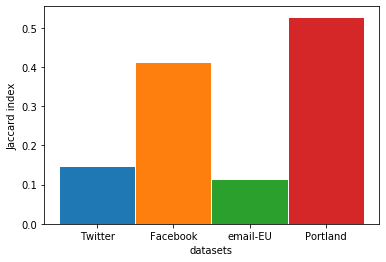

In [79]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import operator as o

import numpy as np

plt.rcParams.update({'font.size': 10})
weights = np.ones_like(anti_cluster_coef_list)/float(len(anti_cluster_coef_list))

dataset = [
    "Twitter-combined",
    "Facebook-combined",
    "email-Eu-core",
    "Portland"
]


barWidth = 0.25
bars=[[0.14856861780619773], 
      [0.4129244249726177],
      [0.11312217194570136],
      [0.5280382647682251]
]

# Set position of bar on X axis
r = np.zeros_like(bars)
r[0] = np.arange(len(bars[0]))
for i in range(1,len(r)):
  for j in range(0, len(r[0])):
    r[i][j] = r[i-1][j] + barWidth

# Make the plot
for i in range(len(bars)):
  plt.bar(r[i], bars[i],  width=barWidth, edgecolor='white', label=dataset[i])

 
# Add xticks on the middle of the group bars
plt.xlabel('datasets')
plt.ylabel('Jaccard index')
plt.xticks([r/4  for r in range(len(bars))], ['Twitter', 'Facebook', 'email-EU', 'Portland', '-', '-'])
# Create legend & Show graphic
# plt.legend(loc='upper right', bbox_to_anchor=(0, 0))
# plt.legend()
plt.show()


In [ ]:
# TO_PLOT = 20

# def boxplot_histogram(dict1, bins=5):
#   labels = [key for key in sorted(dict1.keys())]
#   data =  [dict1[key] for key in sorted(dict1.keys())]


#   hist_data = []
#   hist_label = []
#   local_data = []
#   for i in range(len(data)):
#     local_data.extend(data[i])
#     if(i!=0 and i%bins == 0):
#       hist_data.append(local_data)
#       hist_label.append(labels[i])
#       local_data = []

#   if(local_data != []):
#       hist_data.append(local_data)
#       hist_label.append(labels[-1])

#   # print(hist_data[15])
#   # print(hist_label)

#   plt.rcParams.update({'font.size': 10})
#   plt.boxplot(hist_data[:TO_PLOT])
#   plt.xticks(range(1, TO_PLOT+1), hist_label[:TO_PLOT])
#   plt.xlabel("Degree of nodes in NE")
#   plt.ylabel("Number of nodes")
#   # plt.show()
#   # fig = plt.gcf()
#   # fig.set_size_inches(20, 15)
#   # fig.savefig('boxplot.png', dpi=200)



# RUN_THIS = True

# if RUN_THIS:
#   anti_degree_global_count = load_obj('anti_degree_global_count')

#   boxplot_histogram(anti_degree_global_count, bins=5)

In [ ]:
# from math import log
# TO_PLOT = 100

# def boxplot_histogram(dict1, bins=5):
#   labels = [key for key in sorted(dict1.keys())][:TO_PLOT]
#   data =  [ log(sum(dict1[key])/len(dict1[key])) for key in sorted(dict1.keys())][:TO_PLOT]
#   data = [i if i==0 else log(i) for i in data]

#   print(labels)
#   print(data)


#   # plt.rcParams.update({'font.size': 10})
#   plt.plot(labels, data)
#   # plt.xticks(range(1, len(hist_data) +1), hist_label)
#   plt.xlabel("Degree of nodes in NE")
#   plt.ylabel("log(Number of anti-vaccine nodes)")
#   plt.show()
#   # fig = plt.gcf()
#   # fig.set_size_inches(20, 15)
#   # fig.savefig('boxplot.png', dpi=200)



# RUN_THIS = True

# if RUN_THIS:
#   anti_degree_global_count = load_obj('anti_degree_global_count')

#   boxplot_histogram(anti_degree_global_count, bins=5)

In [ ]:
# # g = nx.read_edgelist("twitter_combined.txt", create_using = nx.Graph(), nodetype=int) ########### snap twitter data #############
 
# # g = nx.read_edgelist("facebook_combined.txt", create_using = nx.Graph(), nodetype=int) ########### snap facebook data #############

# g = nx.read_edgelist("email-Eu-core.txt", create_using = nx.Graph(), nodetype=int) ########### snap email-Eu-core data #############


# # g = nx.read_edgelist("G_bter_ca-AstroPh-simple.txt", create_using = nx.Graph(), nodetype=int) ########### snap astoph data #############


# clustering = nx.clustering(g)
# plt.rcParams.update({'font.size': 12})
# # weights = np.ones_like(list(anti_cluster_coef_list))/len(anti_cluster_coef_list)
# weights = np.ones_like(list(clustering.values()))/len(clustering.values())

# print(clustering.values())
# plt.xlabel('Clustering coefficient')
# # plt.hist(anti_cluster_coef_list, weights = weights, bins = 40)
# plt.hist(clustering.values(), weights = weights, bins = 40)


In [ ]:
# ##### Experiment 4
# ##### histogram curve varied with parameters

# RUN_THIS = True
# PARALLEL = True
# INIT_LIST = ["random", "degree", "cluster"]


# #
# alpha = 1
# beta = 1
# # gamma = 0.9
# # C = 70
# # delta = 35 ## herd immunity does not guarantee total immunity
# C_list = [1, 2, 4]
# gamma_list = [0.9]
# delta_list = [1, 2]

# PROB_PRO = 0.7
# PROB_NEUTRAL = 0.0
# PROB_ANTI = 0.3

# if RUN_THIS and __name__ == "__main__":

#   for INIT in INIT_LIST:

#     NUM_ITER = INIT
#     init_sentiments_dict = get_init_sentiments(INIT = INIT, graph= g, PROB_ANTI= PROB_ANTI)  

#     lines = []

#     for gamma, C, delta in itertools.product(gamma_list, C_list, delta_list):
#       if(delta > C):
#         continue

#       if (PARALLEL):
#         antivax_history, t, strategyNE = simulate_parallel(TMAX = 20, verbose = 0, graph=g, strategy= init_sentiments_dict, alpha = alpha, beta=beta, gamma=gamma, C = C, delta = delta) 
#       else:
#         antivax_history, t, strategyNE = simulate_sequential(verbose = 0, graph=g, strategy= init_sentiments_dict, alpha = alpha, beta=beta, gamma=gamma, C = C, delta = delta) 
                  
#       antivaxNE = get_antivax(strategyNE)

#       for i in antivaxNE:
#         anti_cluster_coef_list.append(nx.clustering(g,i))
#       plt.legend()
      

#     plt.rcParams.update({'font.size': 8})
#     labels = [l.get_label() for l in lines]
#     plt.legend(lines, labels)
#     plt.show()
    

In [ ]:
# plt.hist(anti_degree_list, bins = 'auto', label="Histogram of degree of Antivaccine nodes in NE")
# plt.hist(anti_cluster_coef_list, bins='auto')

# def boxplot_dictionary_in_chunks(dict1, split):
#   # labels, data = [*zip(*dict1.items())]  # 'transpose' items to parallel key, value lists

#   # or backwards compatable    
#   labels = [key for key in sorted(dict1.keys())]
#   data =  [dict1[key] for key in sorted(dict1.keys())]

#   chunk = len(data)//split

#   for i in range(split):
#     plt.boxplot(data[i* chunk : (i+1)*chunk])
#     plt.xticks(range(1 , chunk+1), labels[i* chunk: (i+1)*chunk])
#     plt.xlabel("Degree of nodes in NE")
#     plt.ylabel("Number of nodes")
#     plt.show()

#     # fig = plt.gcf()
#     # fig.set_size_inches(40, 5)
#     # fig.savefig('boxplot.png', dpi=200)


#   plt.boxplot(data[split* chunk : -1])
#   plt.xticks(range(len(labels[split* chunk : -1])), labels[split* chunk : -1])
#   plt.xlabel("Degree of nodes in NE")
#   plt.ylabel("Number of nodes")
#   plt.show()


# RUN_THIS = False

# if RUN_THIS:
#   boxplot_dictionary_in_chunks(anti_degree_global_count, split=6)

In [ ]:
# ### connect subgraph and make them antivax
# #########################################

# RUN_THIS = True
# INIT = "random"

# k = 100
# S = random.sample(range(g.number_of_nodes()), k)

# for i in S:
#   for j in S:
#     if not g.has_edge(i,j):
#       g.add_edge(i,j)


# #### this script plots histogram of number of epochs for NE
# ## varying the init strategy vector with fixed probabilities

# alpha = 0
# beta = 1
# # gamma = 0.9
# # C = 70
# # delta = 35 ## herd immunity does not guarantee total immunity
# C_list = [0]
# gamma_list = [0.9]
# delta_list = [35]

# PROB_PRO = 0.7
# PROB_NEUTRAL = 0.0
# PROB_ANTI = 0.3

# if RUN_THIS and __name__ == "__main__":

#   epoch_list = []
  
#   for gamma in gamma_list:
#     for delta in delta_list:
#       for C in C_list:


#         init_sentiments_dict = get_init_sentiments()

#         make_antivax(init_sentiments_dict, S)

#         antivax_history, t, strategyNE = simulate_sequential(verbose = 1, graph=g, strategy= init_sentiments_dict, alpha = alpha, beta=beta, gamma=gamma, C = C, delta = delta) 

#         plot(x = range(len(antivax_history)), y = antivax_history, title = "gamma = {}, delta = {}, C = {}".format(gamma, delta, C), xlabel="# Epochs", ylabel="# Antivaccine nodes")


#   print( is_subset( S, get_antivax(strategyNE=strategyNE) ) )
#   print(S)
#   print(get_antivax( strategyNE= strategyNE))

degree random
...
...
...
...
...
...
...
...
...
...
δ = 1, C = 2
...
...
...
antivax at time  0 :  11  Probability:  0.011
...
antivax at time  0 :  21  Probability:  0.021
...
...
...
...
...
antivax at time  0 :  41  Probability:  0.041
...
δ = 1, C = 4
...
...
...
...
...
antivax at time  0 :  24  Probability:  0.024
...
...
...
...
...
δ = 2, C = 2
...
...
...
...
...
...
...
...
...
...
δ = 2, C = 4


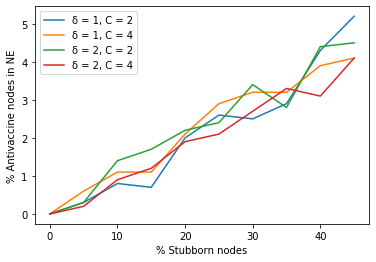

degree degree
...
...
...
...
...
...
...
...
...
...
δ = 1, C = 2
...
...
...
...
...
...
...
...
...
...
δ = 1, C = 4
...
...
...
...
...
...
...
...
...
...
δ = 2, C = 2
...
...
...
...
...
...
...
...
...
...
δ = 2, C = 4


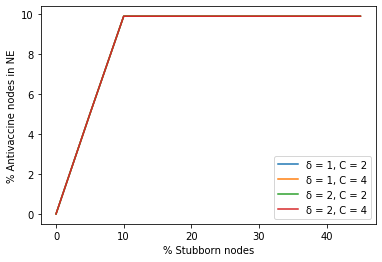

degree cluster
...
antivax at time  0 :  0  Probability:  0.0
...
...
antivax at time  0 :  0  Probability:  0.0
...
...
...
...
...
antivax at time  0 :  0  Probability:  0.0
...
...
δ = 1, C = 2
...
antivax at time  0 :  0  Probability:  0.0
...
...
antivax at time  0 :  0  Probability:  0.0
...
...
...
...
...
...
...
δ = 1, C = 4
...
...
...
...
...
...
...
...
...
...
δ = 2, C = 2
...
...
...
...
...
...
...
antivax at time  0 :  0  Probability:  0.0
...
...
...
δ = 2, C = 4


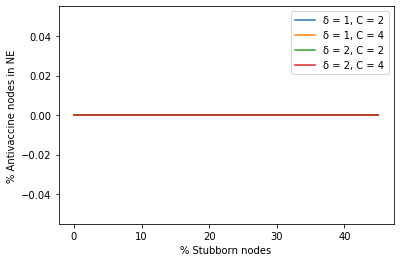

cluster random
...
...
antivax at time  0 :  9  Probability:  0.009
...
...
...
...
...
...
...
...
δ = 1, C = 2
...
...
...
antivax at time  0 :  16  Probability:  0.016
...
...
...
...
...
...
...
δ = 1, C = 4
antivax at time  0 :  0  Probability:  0.0
...
...
...
...
...
...
...
...
...
...
δ = 2, C = 2
...
...
...
...
antivax at time  0 :  18  Probability:  0.018
...
...
...
...
...
...
δ = 2, C = 4


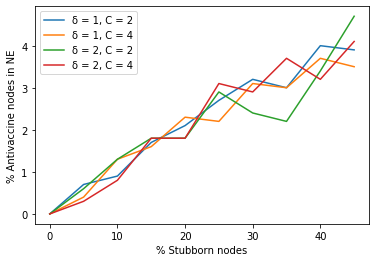

cluster degree
...
...
...
...
antivax at time  0 :  0  Probability:  0.0
...
...
...
...
...
...
δ = 1, C = 2
...
...
...
...
...
...
...
...
...
...
δ = 1, C = 4
...
antivax at time  0 :  0  Probability:  0.0
...
...
...
...
...
...
antivax at time  0 :  0  Probability:  0.0
...
...
...
δ = 2, C = 2
...
...
...
...
...
...
...
...
...
...
δ = 2, C = 4


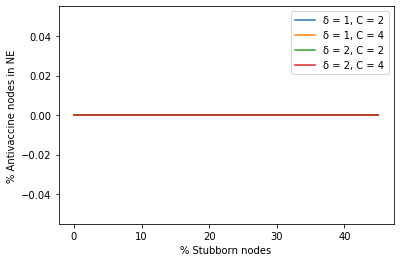

cluster cluster
...
...
...
...
...
...
...
...
...
...
δ = 1, C = 2
...
...
...
...
...
...
...
...
...
...
δ = 1, C = 4
...
...
...
...
...
...
...
...
...
...
δ = 2, C = 2
...
...
...
...
...
...
...
...
...
...
δ = 2, C = 4


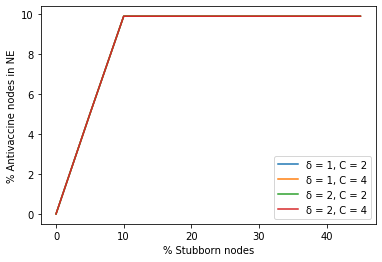

In [ ]:
# ## Experiment 5
# ### stubborn nodes
# #########################################

# # g = nx.read_edgelist("p2p-Gnutella04.txt", create_using = nx.Graph(), nodetype=int) ########### snap gnutella04 data #############

# # ############# params of graph ############################
# N = 1000
# M = 20
# PROB_TRIANGLE = 0.7
# # #########################################################

# g = nx.newman_watts_strogatz_graph(N, M, PROB_TRIANGLE, seed=42) ########### toy data #######



# RUN_THIS = True

# PARALLEL = False

# INIT_LIST = ["degree","cluster"]
# STUBBORN_TYPES_LIST = ["random", "degree", "cluster"]

# alpha = 1
# beta = 1
# # gamma = 0.9
# # C = 70
# # delta = 35 ## herd immunity does not guarantee total immunity
# C_list = [2,4]
# gamma_list = [0.9]
# delta_list = [1,2]

# PROB_STUBBORN_LIST = np.arange(0, 0.5, 0.05)
# PROB_PRO = 0.9
# PROB_ANTI = 1 - PROB_PRO

# NUMBER_OF_INIT_STRATEGY = 1

# if RUN_THIS and __name__ == "__main__":


#   net_size = len(g)
#   for INIT, STUBBORN_TYPE in itertools.product(INIT_LIST, STUBBORN_TYPES_LIST):

#     print(INIT, STUBBORN_TYPE)


#     epoch_list = []
#     labels = []
#     lines = []
#     for gamma, delta, C in itertools.product(gamma_list, delta_list, C_list):
#       if(delta > C):
#         continue
#       local_list = []

#       NUM_ITER = NUMBER_OF_INIT_STRATEGY if INIT=="random" else 1
      
#       antivax_size = []
#       for PROB_STUBBORN in PROB_STUBBORN_LIST:
#         init_sentiments_dict = get_init_sentiments(INIT = INIT, graph = g, PROB_ANTI = PROB_ANTI)
#         stubborn = get_stubborn_nodes(graph = g, PROB_STUBBORN = PROB_STUBBORN, STUBBORN_TYPE = STUBBORN_TYPE )


#         if (PARALLEL):
#           antivax_history, t, strategyNE = simulate_parallel(stubborn = stubborn, TMAX = 20, verbose = 0, 
#                                                             graph=g, strategy= init_sentiments_dict, alpha = alpha, beta=beta, gamma=gamma, C = C, delta = delta) 
#         else:
#           antivax_history, t, strategyNE = simulate_sequential(stubborn = stubborn,
#                                                               verbose = 0.1, graph=g, strategy= init_sentiments_dict, alpha = alpha, beta=beta, gamma=gamma, C = C, delta = delta) 

#         print("...")
#         antivax_size.append(len(get_antivax(strategyNE=strategyNE))/net_size*100)

#       label = "\u03B4 = {}, C = {}".format(delta, C)
#       print(label)
#       lines += plot(showplot=False, x = PROB_STUBBORN_LIST*100, y = antivax_size, title="", 
#                     label = label, xlabel="% Stubborn nodes", ylabel="% Antivaccine nodes in NE")
#       labels.append(label)
#       # plt.show()
#       # plt.legend()

#     plt.legend(lines, labels)
#     plt.show()


degree
...
antivax at time  1 :  384  Probability:  0.09507303788066353
...
antivax at time  1 :  859  Probability:  0.21267640505075514
...
antivax at time  1 :  962  Probability:  0.23817776677395394
...
antivax at time  1 :  1444  Probability:  0.3575142361970785
antivax at time  7 :  1763  Probability:  0.4364941817281505
...
antivax at time  1 :  1786  Probability:  0.4421886605595444
antivax at time  7 :  2291  Probability:  0.5672196088140629
antivax at time  9 :  2324  Probability:  0.5753899480069324
antivax at time  12 :  2335  Probability:  0.5781133944045556
...
antivax at time  1 :  2131  Probability:  0.5276058430304531
antivax at time  7 :  2672  Probability:  0.6615498885862837
antivax at time  9 :  2697  Probability:  0.6677395394899728
antivax at time  12 :  2707  Probability:  0.6702153998514484
...
antivax at time  1 :  2567  Probability:  0.6355533547907898
antivax at time  7 :  2831  Probability:  0.700916068333746
antivax at time  9 :  2840  Probability:  0.70314

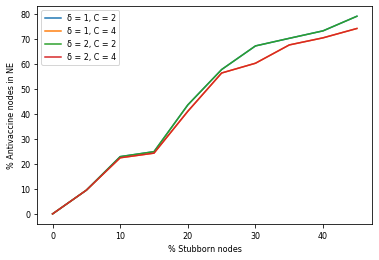

In [ ]:
## Experiment 6
## only stubborn nodes are anti-vaxx


## Experiment 5
### stubborn nodes
#########################################


RUN_THIS = True

PARALLEL = False

STUBBORN_TYPES_LIST = ["degree"]

alpha = 1
beta = 1
# gamma = 0.9
# C = 70
# delta = 35 ## herd immunity does not guarantee total immunity
C_list = [2,4]
gamma_list = [0.9]
delta_list = [1,2]

PROB_STUBBORN_LIST = np.arange(0, 0.5, 0.05)
PROB_PRO = 1
PROB_ANTI = 1 - PROB_PRO

NUMBER_OF_INIT_STRATEGY = 1

INIT = "random"

if RUN_THIS and __name__ == "__main__":

  net_size = len(g)
  for STUBBORN_TYPE in STUBBORN_TYPES_LIST:

    print(STUBBORN_TYPE)

    epoch_list = []
    labels = []
    lines = []
    for gamma, delta, C in itertools.product(gamma_list, delta_list, C_list):
      if(delta > C):
        continue
      local_list = []

      NUM_ITER = NUMBER_OF_INIT_STRATEGY if INIT=="random" else 1
      
      antivax_size = []
      for PROB_STUBBORN in PROB_STUBBORN_LIST:
        init_sentiments_dict = get_init_sentiments(INIT = INIT, graph = g, PROB_ANTI = PROB_ANTI)
        stubborn = get_stubborn_nodes(graph = g, PROB_STUBBORN = PROB_STUBBORN, STUBBORN_TYPE = STUBBORN_TYPE )

        init_sentiment_dict = make_antivax(init_sentiments_dict, stubborn)


        if (PARALLEL):
          antivax_history, t, strategyNE = simulate_parallel(stubborn = stubborn, TMAX = 20, verbose = 0, 
                                                            graph=g, strategy= init_sentiments_dict, alpha = alpha, beta=beta, gamma=gamma, C = C, delta = delta) 
        else:
          antivax_history, t, strategyNE = simulate_sequential(stubborn = stubborn,
                                                              verbose = 0.1, graph=g, strategy= init_sentiments_dict, alpha = alpha, beta=beta, gamma=gamma, C = C, delta = delta) 

        print("...")
        antivax_size.append(len(get_antivax(strategyNE=strategyNE))/net_size*100)

      label = "\u03B4 = {}, C = {}".format(delta, C)
      print(label)
      lines += plot(showplot=False, x = PROB_STUBBORN_LIST*100, y = antivax_size, title="", 
                    label = label, xlabel="% Stubborn nodes", ylabel="% Antivaccine nodes in NE")
      labels.append(label)
      # plt.show()
      # plt.legend()

    plt.legend(lines, labels)
    plt.show()


In [ ]:
## Experiment 7
## K-core

import matplotlib.pyplot as plt


g = nx.read_edgelist("portland.txt", create_using = nx.Graph(), nodetype=int) 
## Experiment 5
### stubborn nodes
#########################################


RUN_THIS = True

PARALLEL = False

INIT_LIST = ["centrality"]
STUBBORN_TYPES_LIST = ["centrality"]

alpha = 1
beta = 1
# gamma = 0.9
# C = 70
# delta = 35 ## herd immunity does not guarantee total immunity
C_list = [4]
gamma_list = [0.9]
delta_list = [1]

PROB_STUBBORN_LIST = np.arange(0, 0.5, 0.05)
PROB_PRO = 0.9
PROB_ANTI = 1 - PROB_PRO

NUMBER_OF_INIT_STRATEGY = 1

if RUN_THIS and __name__ == "__main__":


  net_size = len(g)
  for INIT, STUBBORN_TYPE in itertools.product(INIT_LIST, STUBBORN_TYPES_LIST):

    print(INIT, STUBBORN_TYPE)


    epoch_list = []
    labels = []
    lines = []
    for gamma, delta, C in itertools.product(gamma_list, delta_list, C_list):
      if(delta > C):
        continue
      local_list = []

      NUM_ITER = NUMBER_OF_INIT_STRATEGY if INIT=="random" else 1
      
      antivax_size = []
      for PROB_STUBBORN in PROB_STUBBORN_LIST:
        init_sentiments_dict = get_init_sentiments(INIT = INIT, graph = g, PROB_ANTI = PROB_ANTI)
        stubborn = get_stubborn_nodes(graph = g, PROB_STUBBORN = PROB_STUBBORN, STUBBORN_TYPE = STUBBORN_TYPE )


        if (PARALLEL):
          antivax_history, t, strategyNE = simulate_parallel(stubborn = stubborn, TMAX = 20, verbose = 0, 
                                                            graph=g, strategy= init_sentiments_dict, alpha = alpha, beta=beta, gamma=gamma, C = C, delta = delta) 
        else:
          antivax_history, t, strategyNE = simulate_sequential(stubborn = stubborn,
                                                              verbose = 0.1, graph=g, strategy= init_sentiments_dict, alpha = alpha, beta=beta, gamma=gamma, C = C, delta = delta) 

        print("...")
        antivax_size.append(len(get_antivax(strategyNE=strategyNE))/net_size*100)

      anti_vax_nodes = get_antivax(strategyNE)
      anti_vax_subgraph = g.subgraph(anti_vax_nodes)

      core_dict = nx.algorithms.core.core_number(anti_vax_subgraph)
      plt.hist(core_dict.values(), bins = 'auto')
      plt.show()

In [ ]:
nx.algorithms.core.core_number??